In [146]:
######### MODULES ##########
import sys, os, re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from scipy import interpolate as spinter, ndimage as spimg
plt.rcParams.update({'font.size':16})
np.set_printoptions(threshold=sys.maxsize)

In [147]:
relitive_path = "data\\"
file_names = os.listdir(relitive_path) # lists out the names of all files in the working directory
shots= ["8","13","14","37","39"]

filtered_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*Ch1.csv", file_name))]
shot_no = [int(re.search(".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*Ch1.csv", filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]

shot_no

[13, 14, 8]

In [148]:
######## FUNCTIONS #########

def read_data(shot, silent= False):
    ###FIND MATCHING FILE NAMES
    relitive_path = "data\\"
    file_names = os.listdir(relitive_path) # lists out the names of all files in the working directory
    kirills_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT"+ str(shot) + "[^0-9]*[0-9]{3}[^0-9].*.csv", file_name))]
    phils_file_names = [file_name for file_name in file_names if len(re.findall("(?i)s0*{:d}[^0-9]*\.csv".format(shot) , file_name))]
    xray_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT{:d}.tif".format(shot) , file_name))]
    filtered_file_names = kirills_file_names + phils_file_names + xray_file_names
    ###PRINT FILE INFO
    if not silent: # remember to do silent == True if you use read_data in a loop
        print("Found {:d} files:".format(len(filtered_file_names)))
        [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]
    ###PUT OSCILLOSCOPE FILES INTO DICTIONARY
    dictionary = {}
    for phils_file_name in phils_file_names: # should only be 1 file
        for n, column in enumerate(["time","bdot","tof","diode"]): # some data files have Ch4 but it's just noise.
            dictionary[column] = np.genfromtxt(relitive_path+phils_file_name, delimiter=',', skip_header =18, usecols=n)
    ###PUT THZ FILES INTO DICTIONARY
    for kirill_file_name in kirills_file_names: # should only be 2 files
        for Ch in ["Ch1","Ch2","Ch3","Ch4"]:
            if Ch in kirill_file_name : channel = Ch # Python has got some weird ways of writing if statements.
        dictionary["pyro_time"], dictionary[channel] = np.genfromtxt(relitive_path+kirill_file_name, delimiter=',', skip_header =0, usecols=(3,4)).T
    ###PUT XRAY FILES INTO DICTIONARY
    for xray_file_name in xray_file_names: # should only be 2 files
        raw = "_raw" if "raw" in xray_file_name else ""
        dictionary["xray" + raw] = np.array(Image.open(relitive_path+xray_file_name))

    return dictionary

def read_lots_of_data(shots, requested_data, silent= False): #read_data is too slow because it reads all files. Sorry that this is messy. The're a lot of regex codes and list comprehentions.
    relitive_path = "data\\"
    file_names = os.listdir(relitive_path) # lists out the names of all files in the working directory
    shots = np.array([str(shot) for shot in shots])
    dictionary = {}
    oscilloscope_data = ["time","bdot","tof","diode"]
    pyro_data = ["Ch1","Ch2","Ch3","Ch4","pyro_time"]

    if requested_data in pyro_data:
        channel = "Ch1" if requested_data == "pyro_time" else requested_data
        filtered_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*"+channel+".csv", file_name))]
        shot_no = [int(re.search(".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*"+channel+".csv", filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
        for n in range(len(filtered_file_names)):
            dictionary[shot_no[n]] = np.genfromtxt(relitive_path+filtered_file_names[n], delimiter=',', skip_header =0, usecols= 3 if requested_data == "pyro_time" else 4)

    elif requested_data in oscilloscope_data:
        filtered_file_names = [file_name for file_name in file_names if len(re.findall("(?i)s0*("+'|'.join(shots)+")[^0-9]*\.csv", file_name))]
        shot_no = [int(re.search("(?i)s0*("+'|'.join(shots)+")[^0-9]*\.csv", filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
        for n in range(len(filtered_file_names)):
            column = oscilloscope_data.index(requested_data)
            dictionary[shot_no[n]] = np.genfromtxt(relitive_path+filtered_file_names[n], delimiter=',', skip_header =18, usecols= column)

    elif requested_data in ["xray", "xray_raw"]:
        filtered_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT("+'|'.join(shots)+").tif", file_name))]
        shot_no = [int(re.search(".*SHOT("+'|'.join(shots)+").tif", filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
        raw = [True if "raw" in filtered_file_name else False for filtered_file_name in filtered_file_names]
        if requested_data == "xray":
            filtered_file_names = np.array(filtered_file_names)[np.logical_not(raw)]
            shot_no = np.array(shot_no)[np.logical_not(raw)]
        else:
            filtered_file_names = np.array(filtered_file_names)[raw]
            shot_no = np.array(shot_no)[raw]
        for n in range(len(filtered_file_names)):
            dictionary[shot_no[n]] = np.array(Image.open(relitive_path+filtered_file_names[n]))

    elif requested_data == "espec":
        filtered_file_names = [file_name for file_name in file_names if len(re.findall("^IP.*.tif", file_name))]
        #shot number = N/A
        for filtered_file_name in filtered_file_names: # Should be all files as the espec is related to a set of shots as opposed to a single shot.
            dictionary[filtered_file_name] = np.array(Image.open(relitive_path+filtered_file_name))

    else:
        raise ValueError("{0:} is not a recognised data set".format(requested_data))

    if not silent: # remember to do silent == True if you use read_data in a loop
        print("Found {:d} files:".format(len(filtered_file_names)))
        [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]

    return dictionary # dict with the shot number as keys :)

def autocrop(array): #crops to rectangular section with many non-zero values.
    array_exist = array != 0
    row_existance = np.sum(array_exist, axis= 1)
    row_average_existance = np.mean(row_existance)
    column_existance = np.sum(array_exist, axis= 0)
    column_average_existance = np.mean(column_existance)
    first_row, last_row = int(np.argwhere(row_existance > row_average_existance)[0]), int(np.argwhere(row_existance > row_average_existance)[-1])
    first_column, last_column = int(np.argwhere(column_existance > column_average_existance)[0]), int(np.argwhere(column_existance > column_average_existance)[-1])

    return array[first_row:last_row, first_column:last_column]

def dead_pixel_filter(image, dead_pixels =1):
    # Remove the most anomalous 1% of pixels and replace with nearest nearbour.
    upper_percentile = 100 - dead_pixels/2
    lower_percentile = dead_pixels/2
    notdead = np.logical_and(image <= np.percentile(image,upper_percentile), image >= np.percentile(image,lower_percentile) )
    coords = np.mgrid[0:image.shape[0], 0:image.shape[1]]
    coords = np.moveaxis(coords, 0, -1) #refromat the array such that we have pairs of coordinates. ie. [[0,0],[0,1],[0,2]] ect.
    nearest = spinter.NearestNDInterpolator(coords[notdead], image[notdead])
    image = nearest(coords[:,:,0],coords[:,:,1])

    return image

def bandpass_filter(image, minimum_freq =-np.inf, maximum_freq= np.inf): #frequencies are arbitrary.
    image_FFT = np.fft.rfft2(image, norm= "forward")
    image_FFT = np.fft.fftshift(image_FFT, axes= 0)

    image_FFT_flat = image_FFT.flatten()
    total_freqs = len(image_FFT_flat)

    zero_point = (image_FFT.shape[0]//2, 0)
    k = np.mgrid[0:image_FFT.shape[0], 0:image_FFT.shape[1]]
    k = np.moveaxis(k, 0, 2)
    k -= zero_point
    abs_k = np.linalg.norm(k, axis= 2).flatten()

    image_FFT_bandpass = [image_FFT_flat[n] if abs_k[n] > minimum_freq and abs_k[n] < maximum_freq else 0 for n in range(total_freqs)]
    image_FFT_bandpass = np.reshape(image_FFT_bandpass, image_FFT.shape)

    image_bandpass = np.fft.ifftshift(image_FFT_bandpass, axes= 0)
    image_bandpass = np.fft.irfft2(image_bandpass, norm= "forward", s= image.shape)

    return image_bandpass, image_FFT_bandpass

def directional_filter(image, target_angle, angle_tolerance): #angle in degrees

    image_FFT = np.fft.rfft2(image, norm= "forward")
    image_FFT = np.fft.fftshift(image_FFT, axes= 0)

    image_FFT_flat = image_FFT.flatten()
    total_freqs = len(image_FFT_flat)

    zero_point = (image_FFT.shape[0]//2, 0)
    k = np.mgrid[0:image_FFT.shape[0], 0:image_FFT.shape[1]]
    k = np.moveaxis(k, 0, 2)
    k -= zero_point
    theta = np.rad2deg(np.arctan(k[:,:,0]/ k[:,:,1])).flatten()

    minimum_angle = target_angle -angle_tolerance
    maximum_angle = target_angle +angle_tolerance

    image_FFT_directional = [image_FFT_flat[n] if theta[n] > minimum_angle and theta[n] < maximum_angle else 0 for n in range(total_freqs)]
    image_FFT_directional = np.reshape(image_FFT_directional, image_FFT.shape)

    image_directional = np.fft.ifftshift(image_FFT_directional, axes= 0)
    image_directional = np.fft.irfft2(image_directional, norm= "forward", s= image.shape)

    return image_directional, image_FFT_directional

In [149]:
especs = read_lots_of_data([], "espec")
espec = list(especs.values())[0]

espec = autocrop(espec)

Found 2 files:
   IP_26012024.tif
   IP_26012024_scan2.tif


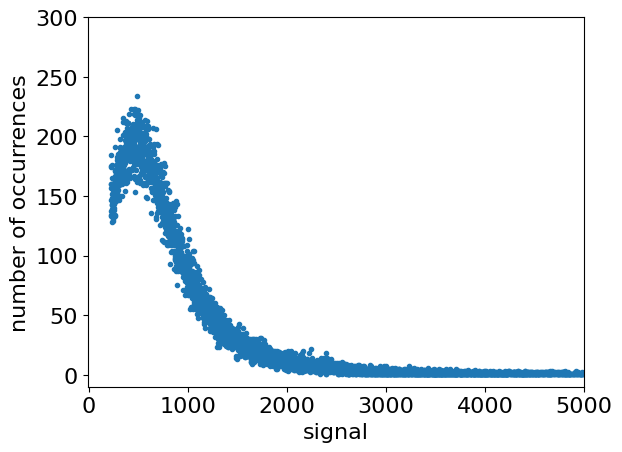

In [150]:
espec_counts = np.array(np.unique(espec, return_counts=True))
espec_counts = espec_counts[:, espec_counts[1].argsort()[::-1]]
espec_counts = [[n, espec_counts[1,espec_counts[0].tolist().index(n)]] if n in espec_counts[0] else [n, np.nan] for n in range(espec.max())]
espec_counts = np.array(espec_counts).T

fig, axs = plt.subplots()

axs.plot(espec_counts[0], espec_counts[1], linestyle= "None", marker= ".")
axs.set(xlim= (-10, 5000), ylim= (-10, 300), xlabel= "signal", ylabel= "number of occurrences")
plt.show()

In [151]:
espec_FFT = np.fft.rfft2(espec, norm= "forward")
espec_FFT = np.fft.fftshift(espec_FFT, axes= 0)

In [152]:
espec_dead = dead_pixel_filter(espec, 1)

espec_FFT_dead = np.fft.rfft2(espec_dead, norm= "forward")
espec_FFT_dead = np.fft.fftshift(espec_FFT_dead, axes= 0)

In [163]:
espec_bandpass, espec_FFT_bandpass = bandpass_filter(espec_dead, 3, 12)

In [154]:

#espec_median = np.sum([spimg.median_filter(espec, size= n) for n in tqdm(range(1, 50))], axis= 0) #This is very slow but pretty cool.
espec_median = spimg.median_filter(espec, size= 20)

espec_FFT_median = np.fft.rfft2(espec_median, norm= "forward")
espec_FFT_median = np.fft.fftshift(espec_FFT_median, axes= 0)

In [155]:
espec_directional, espec_FFT_directional = directional_filter(espec_dead, -60, 30)

C:\Users\syf83691\AppData\Local\Temp\ipykernel_21892\2515163945.py:138: RuntimeWarning: divide by zero encountered in divide
  theta = np.rad2deg(np.arctan(k[:,:,0]/ k[:,:,1])).flatten()
C:\Users\syf83691\AppData\Local\Temp\ipykernel_21892\2515163945.py:138: RuntimeWarning: invalid value encountered in divide
  theta = np.rad2deg(np.arctan(k[:,:,0]/ k[:,:,1])).flatten()


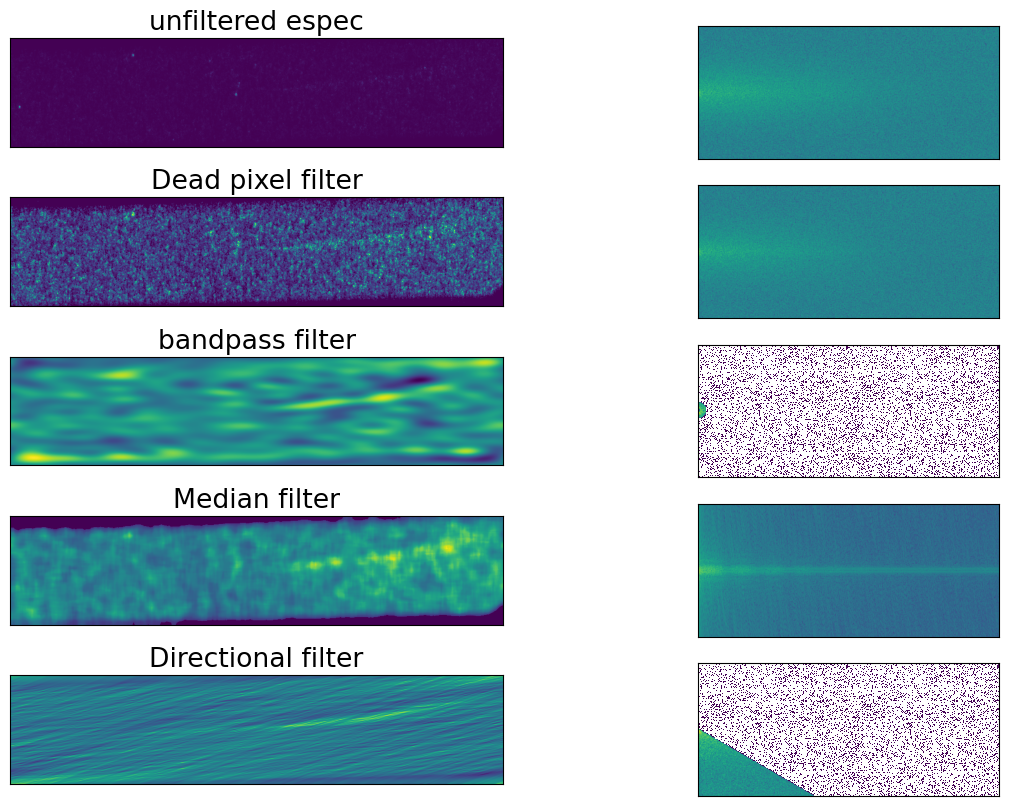

In [164]:
fig, axs = plt.subplots(5,2, figsize= (14, 10))

im1 = axs[0][0].imshow(espec, origin= "lower")
axs[0][0].set(title= "unfiltered espec")
axs[0][1].imshow(np.abs(espec_FFT), norm= "log", aspect= "equal", origin= "lower")
#plt.colorbar(im1)

im2 = axs[1][0].imshow(espec_dead, origin= "lower")
axs[1][0].set(title= "Dead pixel filter")
axs[1][1].imshow(np.abs(espec_FFT_dead), norm= "log", aspect= "equal", origin= "lower")
#plt.colorbar(im2)

im3 = axs[2][0].imshow(espec_bandpass, origin= "lower")
axs[2][0].set(title= "bandpass filter")
axs[2][1].imshow(np.abs(espec_FFT_bandpass), norm= "log", aspect= "equal", origin= "lower")
#plt.colorbar(im3)

im4 = axs[3][0].imshow(espec_median, origin= "lower")
axs[3][0].set(title= "Median filter")
axs[3][1].imshow(np.abs(espec_FFT_median), norm= "log", aspect= "equal", origin= "lower")
#plt.colorbar(im4)

im5 = axs[4][0].imshow(espec_directional, origin= "lower")
axs[4][0].set(title= "Directional filter")
axs[4][1].imshow(np.abs(espec_FFT_directional), norm= "log", aspect= "equal", origin= "lower")
#plt.colorbar(im5)

[ax.set(xticks= [], yticks= []) for ax in axs.flatten()]

plt.show() #The dead pixel filter seems to be the most useful here. S:N is terrible so it's difficult to salvage any infomation even with the filters.

In [157]:
shot_max = 75

In [158]:
xrays = read_lots_of_data(np.arange(shot_max), "xray", silent= True)
xray_max = [np.max(xray) for xray in xrays.values()]
xray_shot_no = list(xrays.keys())

bdots = read_lots_of_data(np.arange(shot_max), "bdot", silent= True)
bdot_max = [np.max(bdot) for bdot in bdots.values()]
bdot_shot_no = list(bdots.keys())

pyros = read_lots_of_data(np.arange(shot_max), "Ch2", silent= True)
pyro_max = [np.max(pyro) for pyro in pyros.values()]
pyro_shot_no = list(pyros.keys())

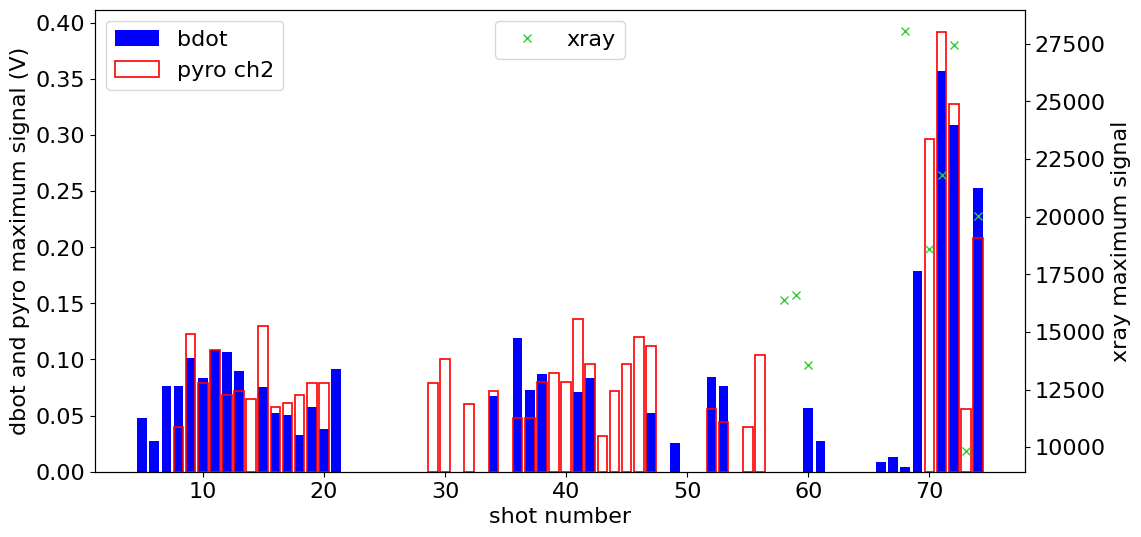

In [159]:
fig, axs = plt.subplots(figsize= (12,6))

axs.bar(bdot_shot_no, bdot_max, color="blue", label= "bdot")
axs.bar(pyro_shot_no, pyro_max, edgecolor='red', color='none', linewidth= 1.2, label= "pyro ch2")
axs.set(xlabel= "shot number", ylabel= "dbot and pyro maximum signal (V)")
plt.legend(loc= "upper left")

twin = axs.twinx()

twin.plot(xray_shot_no, xray_max, linestyle= "None", marker= "x", color= "limegreen", label= "xray")
twin.set(ylabel= "xray maximum signal")

plt.legend(loc= "upper center")
plt.show()

Found 3 files:
   190124FOILSHOT8_001_Ch1.csv
   190124FOILSHOT8_001_Ch2.csv
   s08_ALL.csv
Found 3 files:
   190124FOILSHOT8_001_Ch1.csv
   190124FOILSHOT8_001_Ch2.csv
   s08_ALL.csv


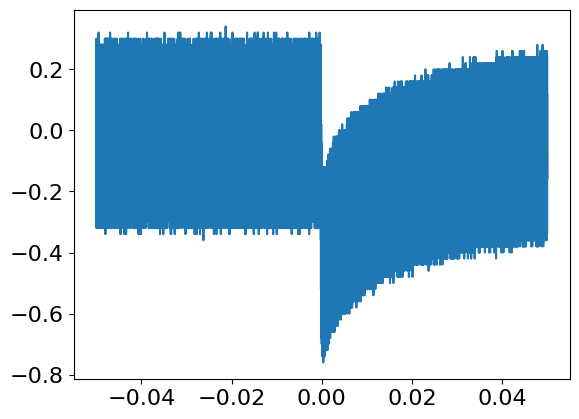

In [160]:
array_time = read_data(8)["pyro_time"]
array_data = read_data(8)["Ch1"]
plt.plot(array_time, array_data)
plt.show()